<a href="https://colab.research.google.com/github/IamSVP94/gender_recognizer/blob/master/NtechLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 1. Программирование

### Описание задачи
Найти непрерывный подмассив в массиве, содержащий хотя бы одно число,
который имеет наибольшую сумму.
### Условия
Необходимо написать программу с функцией findMaxSubArray(A),
принимающей на вход массив целых чисел А ненулевой длины и
возвращающей непрерывный подмассив массива А ненулевой длины,
который имеет наибольшую сумму среди всех непрерывных
подмассивов массива А.
Язык программирования: python
Использование дополнительных библиотек и функций: не разрешается
В качестве решения необходимо прислать ссылку на github.
### Пример
На вход подается массив [-2,1,-3,4,-1,2,1,-5,4]
На выходе функции ожидается массив [4,-1,2,1], имеющий максимальную
сумму среди всех подмассивов равную 6.

In [1]:
def findMaxSubArray(array):
    max_sum = 0  # максимальная сумма подмассива
    subarray = []  # перебор подмассивов
    maxsubarray = []  # для записи подмассива с макс. суммой элементов
    for i in array:
        subarray.append(i)
        if sum(subarray) <= 0:
            subarray = []
        if max_sum < sum(subarray):
            max_sum = sum(subarray)
            maxsubarray = subarray.copy()  # без копирования ссылается на массив sum_list (из-за subarray.append(i) доб. элементы и в max_sum_subarray)
    return maxsubarray

In [2]:
A =  [-2,1,-3,4,-1,2,1,-5,4]
findMaxSubArray(A)

[4, -1, 2, 1]

## Задание 2. ML

### Описание задачи
Необходимо обучить нейросеть, способную по входному изображению лица
определять пол человека на изображении.

### Данные
Для обучения и тестирования будет предоставлен набор из 100 тысяч
картинок, из которых 50 тысяч будут содержать изображения лиц мужчин, а
остальные 50 тысяч - изображения лиц женщин.
В загруженном архиве есть две папки, male и
female, с изображениями лиц мужчин и женщин соответственно. Разбить
данные на тренировочный и валидационный сет предлагается
самостоятельно.
### Условия
В качестве результата необходимо прислать ссылку на github (можно
объединить репозиторий с первой задачей), в котором должны быть:
1. Тренировочный скрипт или notebook-файл с кодом тренировки.
Желательно, чтобы код был закомментирован;
2. Модель обученной нейросети (если модель большая - можно ссылкой на
любой ресурс в описании);
3. Скрипт для использования нейросети, с помощью которого можно
просчитать переданную через аргументы папку с изображениями. Скрипт
должен сохранять файл process_results.json с информацией о результатах
процессинга.<br/>
**Пример вызова**: `python3 process.py folder\to\process\`<br/>
**Пример файла с результатами**: `{ ‘img_1.jpg’: ‘male’, ‘img_2.jpg’: ‘female’, ...}`
4. Описание решения, которое должно включать в себя описание процесса
подготовки данных, используемой нейросети, параметров обучения, и
полученных результатов. Так же в описании должна присутствовать
инструкция для запуска тренировки и запуска нейросети.
5. В качестве фреймворка для обучения желательно использовать pytorch

### Оценка качества
Качество модели будет оцениваться по метрике accuracy.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os
from tqdm import tqdm
import cv2
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn as nn
import torch.nn.functional as F
import torchvision.models as models
import re
from sklearn.metrics import accuracy_score
import tarfile
import albumentations as A

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir_path = '/content/drive/My Drive/Colab Notebooks/NtechLab/'
tar = tarfile.open(dir_path+'internship_data.tar.gz', 'r')

sex_dir = []
for tarinfo in tar:
  if tarinfo.isdir() and 'male' in tarinfo.name and '.' not in tarinfo.name:
    sex_dir.append(tarinfo.name)

df = {}
for sex in sex_dir:
  sex_list = []
  for tarinfo in tar:
    if tarinfo.isfile() and sex in tarinfo.name:
      sex_list.append(tarinfo.name)
  df[re.search('\/\w{4,6}', sex).group(0)[1:]] = sex_list

In [6]:
for sex in df:
  print(len(df[sex]))

50006
50003


В каждом классе одинаковое кол-во элементов, значит что выборка сбалансирована, но вот сами картинки разного размера. Для работы с такими данными, сначала нужно привести их к единому размеру. Изобразим размеры картинок на графике и определим примерный размер медианного разрешения, к которому будем приводить наши картинки.

In [29]:
def resizer(img, mode='original'):
    assert mode in ['original', 'train', 'val'], 'Неизвестный режим resizer'
    label = re.search('\w{0,2}male', img).group(0)
    byte = tar.extractfile(img).read()
    np_array = np.frombuffer(byte, np.uint8)
    img_bgr = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    if mode == 'train':
        transform = A.Compose([
            A.HorizontalFlip(p=0.33), 
            A.ShiftScaleRotate(rotate_limit=15, scale_limit=0, p=0.33), 
            A.HueSaturationValue(p=0.33),
        ], p=0.2)
        return {'img': cv2.resize(transform(image=img_rgb)['image'], (100, 100)), 'label': label}
    elif mode == 'val':
        return {'img': cv2.resize(img_rgb, (100, 100)), 'label': label}
    else:
        return {'img': img_rgb, 'label': label}

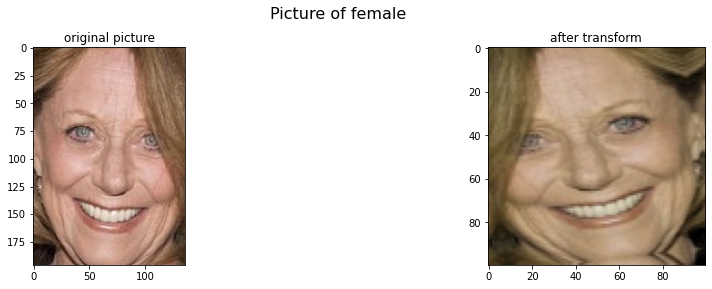

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle(f'Picture of {resizer(img)["label"]}', fontsize=16, y=1.02)
ax[0].imshow(resizer(img)['img'])
ax[1].imshow(resizer(img, mode='train')['img'])
ax[0].set_title('original picture')
ax[1].set_title('after transform');

<hr/>
Разделим всю выборку на тренировочную, валидационную и тестовую в соотношении 85к10к5.

In [30]:
count = len(df['female'])
parts = [85/100, (85+10)/100]
train_ds = [img for img in df['female'][:int(count*parts[0])]] + [img for img in df['male'][:int(count*parts[0])]]
val_ds = [img for img in df['female'][int(count*parts[0]):int(count*parts[1])]] + [img for img in df['male'][int(count*parts[0]):int(count*parts[1])]]
test_ds = [img for img in df['female'][int(count*parts[1]):]] + [img for img in df['male'][int(count*parts[1]):]]

np.random.seed(2)
train_ds = np.random.choice(train_ds, len(train_ds))
np.random.seed(2)
val_ds = np.random.choice(val_ds, len(val_ds))
np.random.seed(2)
test_ds = np.random.choice(test_ds, len(test_ds))

print(len(train_ds), len(val_ds), len(test_ds))
assert len(train_ds)+len(val_ds)+len(test_ds)==len(df['female'])+len(df['male']), 'Есть потеря экземпляров'

85004 10000 5005


In [ ]:
torch.manual_seed(2) # for reproducibility
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('it works on', device)
EPOCHS = 5
batch_size=256
start_learning_rate = 1e-2

net = models.resnet34().to(device)
net.fc = nn.Linear(net.fc.in_features, 2).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = start_learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, eps=1e-8, verbose=True)

train_history = []
val_history = []
for epoch in range(1, EPOCHS+1):
    net.train()
    epoch_losses = 0
    outputs_t = []
    targets_t = []
    for i in tqdm(range(0, len(train_ds), batch_size)):
        batch = train_ds[i:i+batch_size]
        outputs = []
        targets = []
        for j in batch:
          x = resizer(j, mode='train')['img']
          x = torch.from_numpy(x).float().reshape(1,3,100,100).to(device)
          outputs.append(net(x))
          targets.append(0 if resizer(j)['label']=='female' else 1)
          # break
        targets_t = torch.LongTensor(targets)
        outputs_t = torch.cat(outputs, dim=-2)
        loss = criterion(outputs_t, targets_t.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses += loss.item()
        # break
    train_history.append(epoch_losses/len(batch))
    
    net.eval()
    with torch.no_grad():
        epoch_losses = 0
        outputs_v = []
        targets_v = []
        for i in tqdm(range(0, len(val_ds), batch_size)):
            batch = val_ds[i:i+batch_size]
            outputs = []
            targets = []
            for j in batch:
              x = resizer(j, mode='val')['img']
              x = torch.from_numpy(x).float().reshape(1,3,100,100).to(device)
              outputs.append(net(x))
              targets.append(0 if resizer(j)['label']=='female' else 1)
              # break
            targets_v = torch.LongTensor(targets)
            outputs_v = torch.cat(outputs, dim=-2)
            loss = criterion(outputs_v, targets_v.to(device))
            epoch_losses += loss.item()
            # break
        val_history.append(epoch_losses/len(batch))
    
    scheduler.step(val_history[-1])
    print(f'Epoch {epoch}/{EPOCHS}:'.ljust(12, ' '), 
          f'loss: {train_history[-1]}'.ljust(30, ' '), 
          f'val_loss: {val_history[-1]}'.ljust(30, ' '), 
          f'--> Accuracy on validation set: {round(accuracy_score(targets_v.cpu(), torch.argmax(outputs_v, dim=1).cpu())*100, 4)} %'.ljust(30, ' '), 
          sep=' ', end = '\n')

it works on cuda


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 1/5:   loss: 16.3144621104002         val_loss: 2.433342343196273    --> Accuracy on validation set: 81.25 %


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 2/5:   loss: 8.603166135648886        val_loss: 1.6244062297046185   --> Accuracy on validation set: 100.0 %


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 3/5:   loss: 7.005511389424403        val_loss: 1.6036976287141442   --> Accuracy on validation set: 93.75 %


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 4/5:   loss: 6.128124970321854        val_loss: 1.684694000519812    --> Accuracy on validation set: 100.0 %


100%|██████████| 40/40 [01:44<00:00,  2.61s/it]

Epoch 5/5:   loss: 5.715158379326264        val_loss: 1.506811385974288    --> Accuracy on validation set: 87.5 %


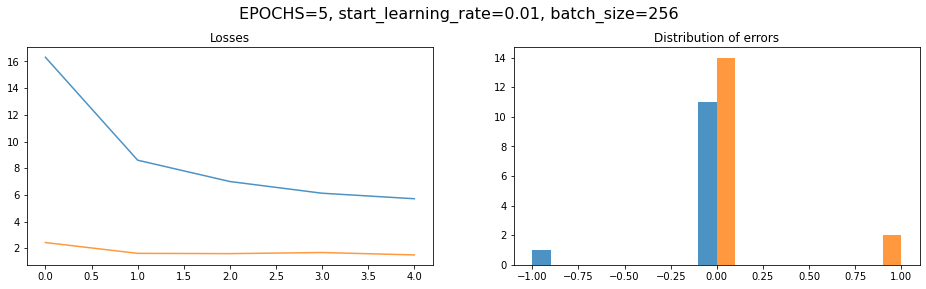

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle(f'EPOCHS={EPOCHS}, start_learning_rate={start_learning_rate}, batch_size={batch_size}', fontsize=16, y=1.02)
ax[0].plot(train_history, alpha=0.8, label='Training loss')
ax[0].plot(val_history, alpha=0.8, label='Validation loss')
ax[0].set_title('Losses')
ax[1].hist((targets_t-torch.argmax(outputs_t.cpu(), dim=1)).detach().numpy(), alpha=0.8)
ax[1].hist((targets_v-torch.argmax(outputs_v.cpu(), dim=1)).detach().numpy(), alpha=0.8)
ax[1].set_title('Distribution of errors');

In [ ]:
torch.save(net,dir_path+'net.pt')

Теперь на оставшивхся данных, которые модель "не видела", и которые мы сохранили в test_ds можно проверить качество работы модели (метрика accuracy):

In [ ]:
def gender_recognizer(img):
  net.eval()
  with torch.no_grad():
    x = resizer(img, mode='val')['img']
    x = torch.from_numpy(x).float().reshape(1, 3, 100, 100).to(device)
    if torch.argmax(net(x)):
      return 'male'
    else:
      return 'female'

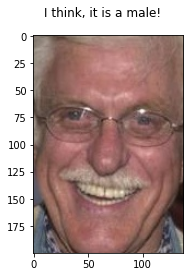

In [ ]:
example = test_ds[2]
plt.imshow(resizer(example)['img'])
plt.suptitle(f'I think, it is a {gender_recognizer(example)}!');

In [ ]:
y_true = [0 if resizer(label)['label']=='female' else 1 for label in test_ds]
y_pred = [0 if gender_recognizer(label)=='female' else 1 for label in test_ds]
print('model accuracy is', round(accuracy_score(y_true, y_pred)*100, 2),'%')

model accuracy is 75.34 %


В последствии, для увеличения качества предсказания модели следует увеличить кол-во эпох для обучения нейросети и снизить learning_rate